A quick tutorial covering the basics of using PyVAN. Another notebook with more advanced usage will be up shortly, but I'm happy to help with questions in the meantime!

You should clone the repository and run the notebook yourself if you'd like to fiddle with the interactive visualizations.

In [1]:
# Imports and display settings:

import pyvan.pyvan as pyvan
import numpy as np
import matplotlib.pyplot as plt
import pkg_resources

# Turn on interactive plotting
%matplotlib notebook

# Widen notebook space to 95% of window size
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))
display

<function IPython.core.display.display>

***
## Example 1:

Here, we're going to load a simulated light-curve from the example directory included with the software. Then, we'll fit it for PyVAN's default templates (flare, quiescent, and RR Lyrae), and explore the results a bit. If you're completely unfamiliar with numpy arrays and python dictionaries, it might be helpful to do a bit of reading first

In [2]:
ex_dir = pkg_resources.resource_filename('pyvan', 'example_data/')

lc_1 = np.genfromtxt(ex_dir+'sim_1.dat', names=True) # Load the first light-curve as a structured numpy array

print lc_1.dtype.names

print lc_1.shape

('mjd', 'mag', 'magErr')
(43,)


As a structured numpy array, "lc_1" is a sort of cross between a typical numpy array and a dictionary

We can treat it like a dictionary of 1d numpy arrays, using the field names 'mjd', 'mag', and 'magErr' like keys:

In [3]:
lc_1['mag']

array([15.43012992, 15.43501992, 15.42877075, 15.43587813, 15.42517488,
       15.4377096 , 15.43358602, 15.42154673, 15.43970577, 15.43823343,
       15.44641828, 15.44036377, 15.44268003, 15.4481875 , 15.42935885,
       15.4474735 , 15.43548412, 15.43452916, 15.45068601, 15.42820532,
       15.46776471, 15.44186714, 15.44052382, 15.45482815, 15.05635248,
       15.34742131, 15.44334046, 15.45725609, 15.43947242, 15.43360183,
       15.41896935, 15.43930178, 15.44601089, 15.44677596, 15.44318455,
       15.44999583, 15.40253166, 15.4270706 , 15.4790432 , 15.43440787,
       15.44683019, 15.43488224, 15.42602454])

But unlike a dictionary, all three parameters of the $i^{th}$ entry can easily be accessed at once:

In [4]:
lc_1[25]

(551.77648372, 15.34742131, 0.00551583)

Fitting the light-curve with PyVAN (this should typically take ~10s or less):

In [5]:
lc_1_fit = pyvan.fit_target(data = lc_1, filt = 'g')

The argument 'filt' indicates that the software should use the g-band filter templates as necessary. For the default templates, this applies to the RR-Lyrae fitting. Default filter options include: u, g, r, i, and z

See documentation for more information about optional arguments

***

The product of pyvan.fit_target is a dictionary containing fit metrics and other information:

The first level contains the follow keys:

In [6]:
print "Keys:"
for key in lc_1_fit:
    print "{} -- {}".format(key, type(lc_1_fit[key]))

Keys:
rel_fit -- <type 'dict'>
fit -- <type 'bool'>
flare -- <type 'dict'>
expt -- <type 'float'>
quiescent -- <type 'dict'>
data -- <type 'numpy.ndarray'>
rrlyrae -- <type 'dict'>


'flare', 'rrlyrae' and 'quiescent' are dictionaries containing information about the respective fits. 

'rel_fit' is a dictionary containing the difference of each template's best-fit log-likelihood with that of the other templates (i.e. lc_1_fit ['rel_fit'] ['flare-rrlyrae'] would give the difference of the flare and RR Lyrae log-likelihoods). These are the metrics we use to eliminate possible contaminants from flare samples.

'fit' is a boolean which indicates whether or not the fit was performed. By default, this would be False if no flare event candidates were identified in the data. 

'data' is the structured numpy array that was fit -- a copy of lc_1 in this case. 

'expt' is the exposure time in seconds. By default, the software assumes 60 second observations, but this can be specified in the arguments of pyvan.fit_target. This is recorded here for repeatability.

---

Looking closer at the contents of one of the template dictionaries contained:

In [7]:
print "Keys:"
for key in lc_1_fit['flare']:
    print "{} -- {}".format(key, type(lc_1_fit['flare'][key]))

Keys:
logL -- <type 'numpy.float64'>
chisq -- <type 'numpy.float64'>
params -- <type 'numpy.ndarray'>
peaks -- <type 'numpy.ndarray'>
fit -- <type 'bool'>


'logL' and 'chisq' give the log-likelihood and chi-squared metric of the best fit flare template respectively

'params' is a 1d array containing the best-fit template parameters.

'peaks' is a 1d array containing the indices of any identified flare candidates

'fit' is a boolean indicating whether or not the flare template fitting was carried out

The other templates' dictionaries will contain similar information, with exceptions as necessitated.

***

We can also see how the fits look: 

<IPython.core.display.Javascript object>


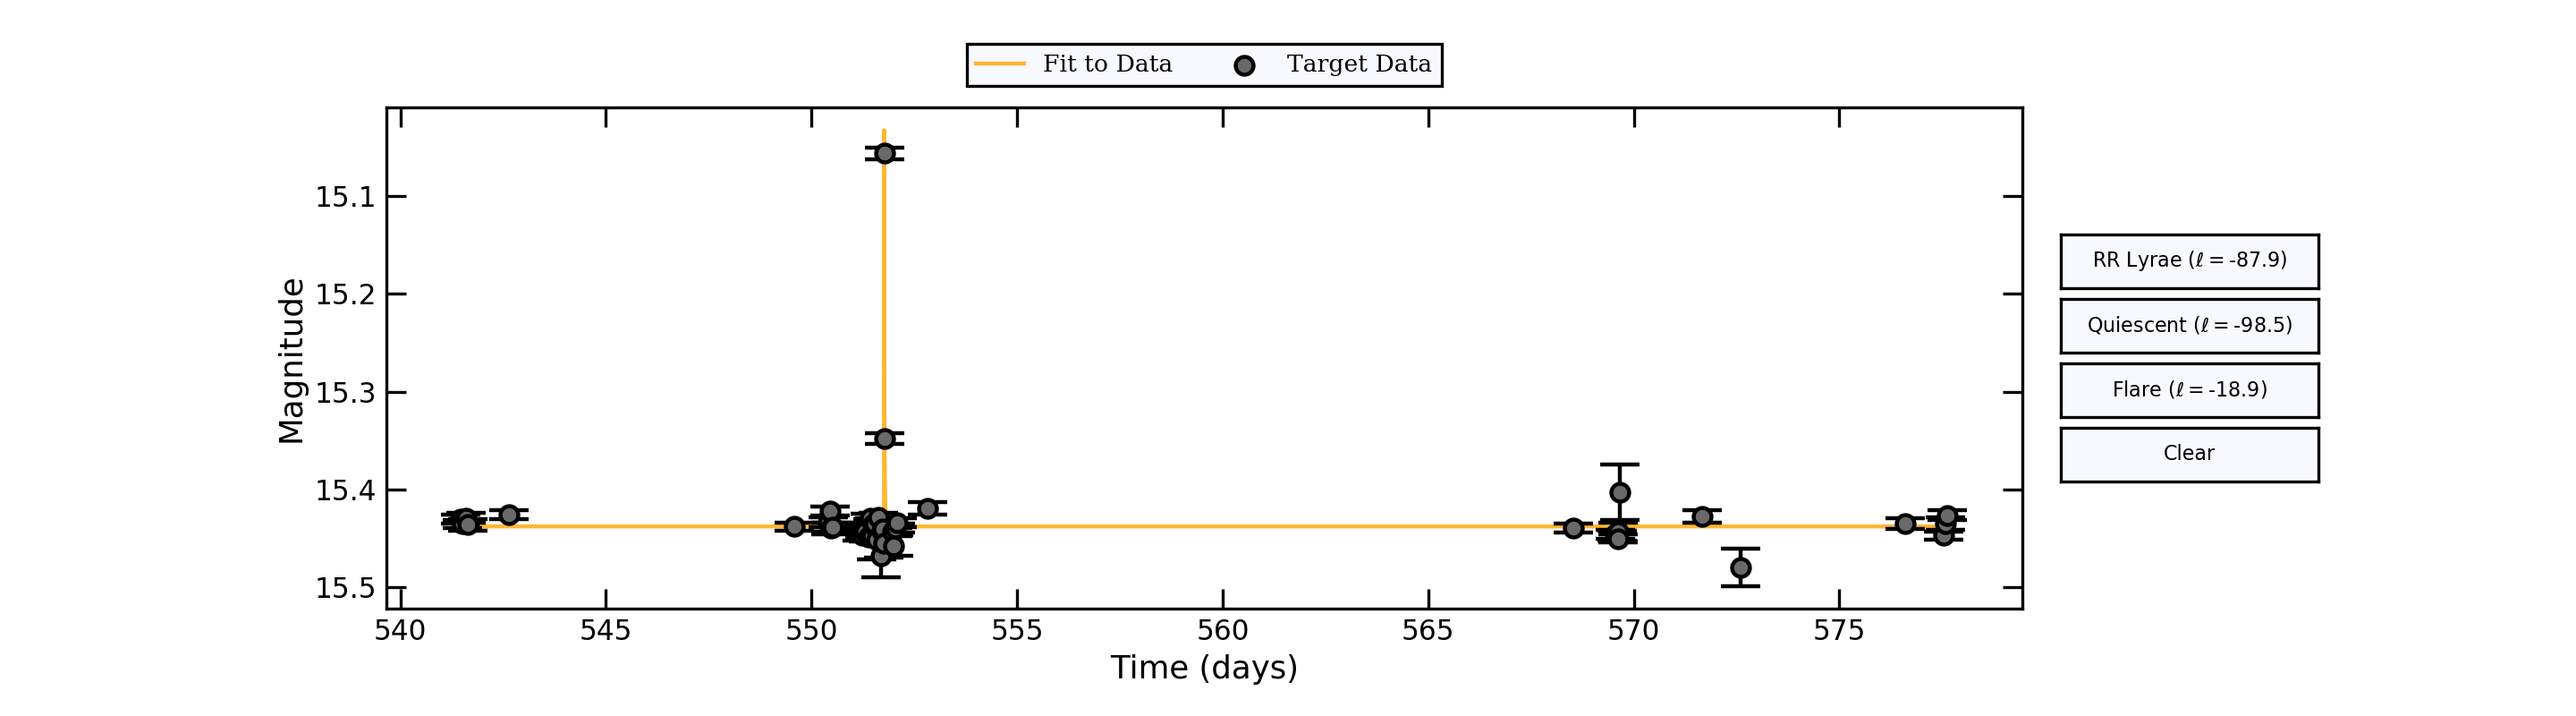

In [8]:
pyvan.plot_all_fits(lc_1_fit)

After executing the cell, clicking any of the options to the right will overlay the respective template fit. Initially, the function displays the most likely fit (the flare template in this case).

Notably, there is always going to be some amount of degeneracy in the determined fit with the flare template--- i.e. there are a range of template parameters that result in fits of the same likelihood. In cases of especially poorly constrained flare start time (i.e. a big gap in observations before the apparent peak), PyVAN may return a fit indicating an event with a much larger amplitude than is directly evidenced. If you're interested in trying to constrain flare energies--- or simply want to present plots of an interesting flare candidate--- you may want to run the fit dictionary through pyvan.tighten_fit 

pyvan.tighten_fit iteratively refits the flare event: first restricting the amplitude to the observed apparent amplitude and checking if a comparable chi-squared is achieved. If the chi-squared is much worse, the amplitude is allowed to go slightly higher, and the fit is re-attempted. This is repeated until a comparable fit is achieved (or until the algorithm reaches the original boundary used for the amplitude). The result is effectively the smallest amplitude flare solution that provides a similar log-likelihood to the original result. If we want to find such a fit for the target above:

In [9]:
tightened_lc_1_fit = pyvan.tighten_flare_fit(lc_1_fit)

print 'Log-Likelihoods before and after tightening:'
print lc_1_fit['flare']['logL'], tightened_lc_1_fit['flare']['logL']

print ''

print 'Amplitudes before and after tightening:'
print lc_1_fit['flare']['params'][3], tightened_lc_1_fit['flare']['params'][3]

Log-Likelihoods before and after tightening:
-18.86736973545282 -18.867369735384596

Amplitudes before and after tightening:
0.40748564963731193 0.38192409410695327


In this case, the software was able to identify a solution at the smaller "apparent" amplitude constrained by observations with a negligible change in likelihood:

<IPython.core.display.Javascript object>


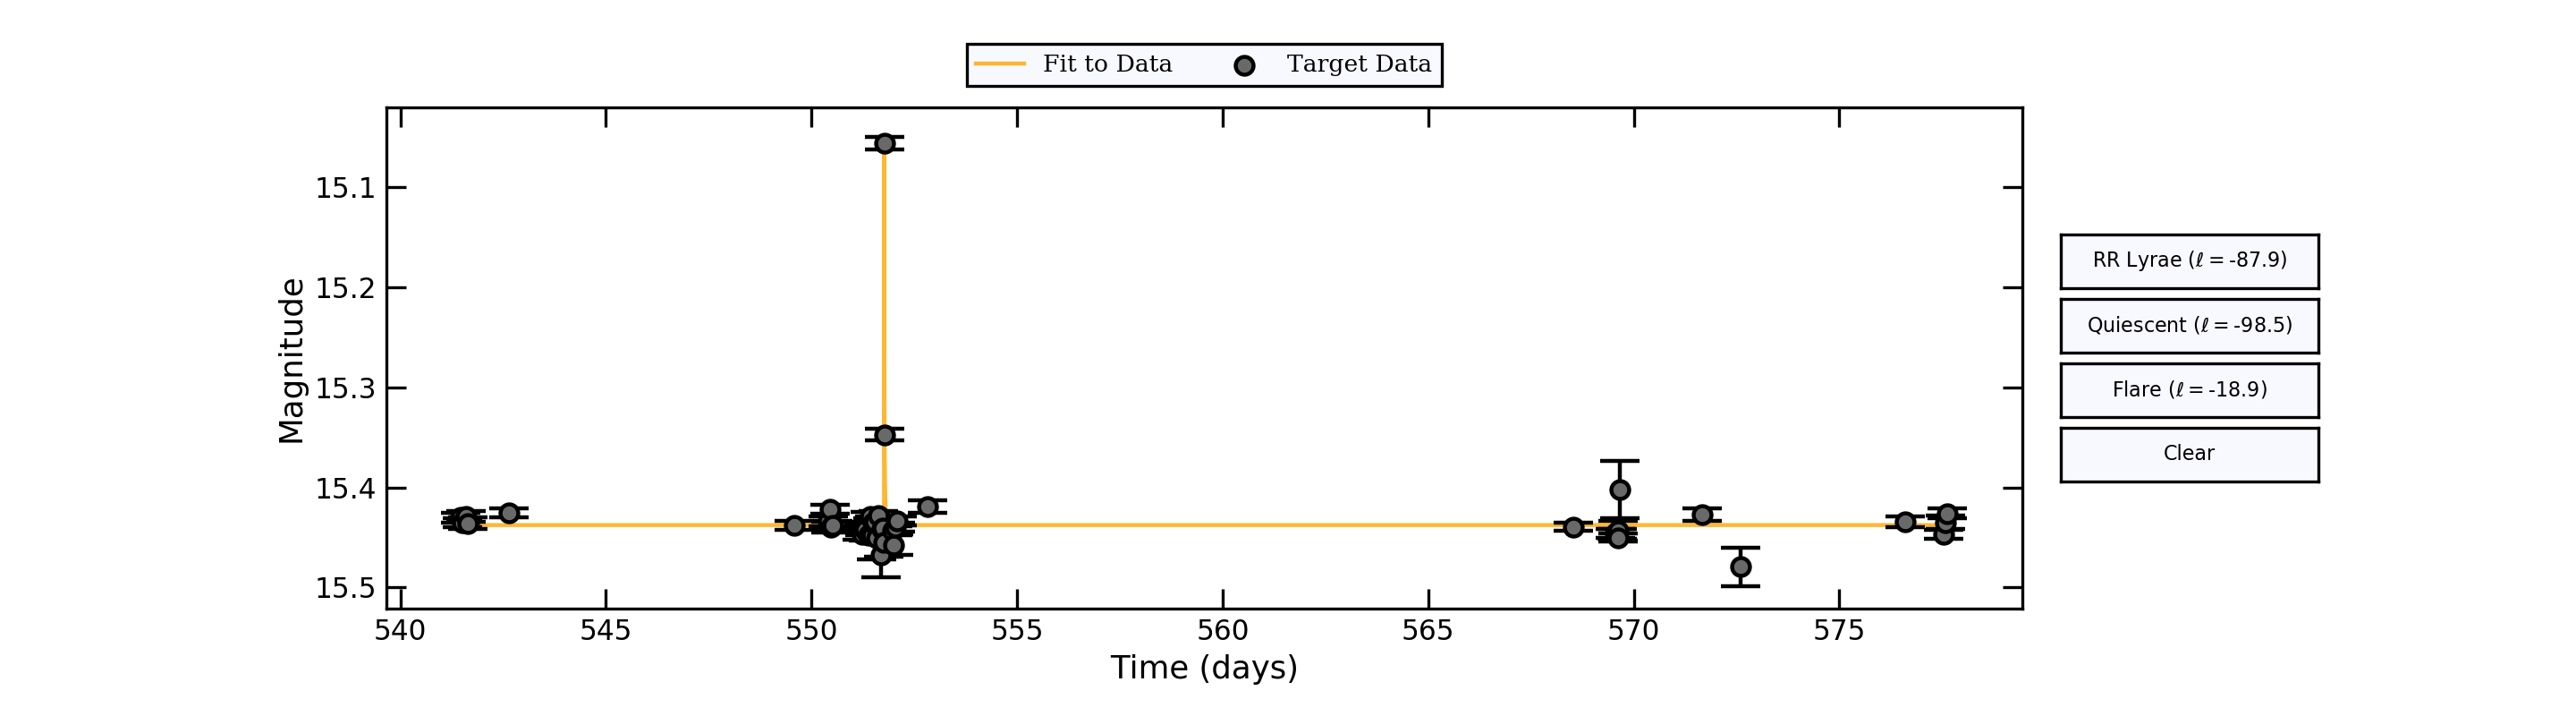

In [10]:
pyvan.plot_all_fits(tightened_lc_1_fit)

__How strong of a flare candidate would this be?__

The corresponding paper found that less than 1% of any contaminant population was found in the region requiring both flare-quiescent and flare-rrlyrae of at least 10.44 and 11.26 respectively. How did this target do?

In [11]:
print lc_1_fit['rel_fit']

{'flare-quiescent': 79.66875363134375, 'quiescent-rrlyrae': -10.65820389399093, 'flare-rrlyrae': 69.01054973735282}


The metrics found for this target indicate that the flare template is strongly preferred to the others tested.

Since this is a simulated light-curve (created by inducing ground based wide-field survey quality in Kepler light-curves), we can plot the result with the original Kepler data utilized: 

<IPython.core.display.Javascript object>


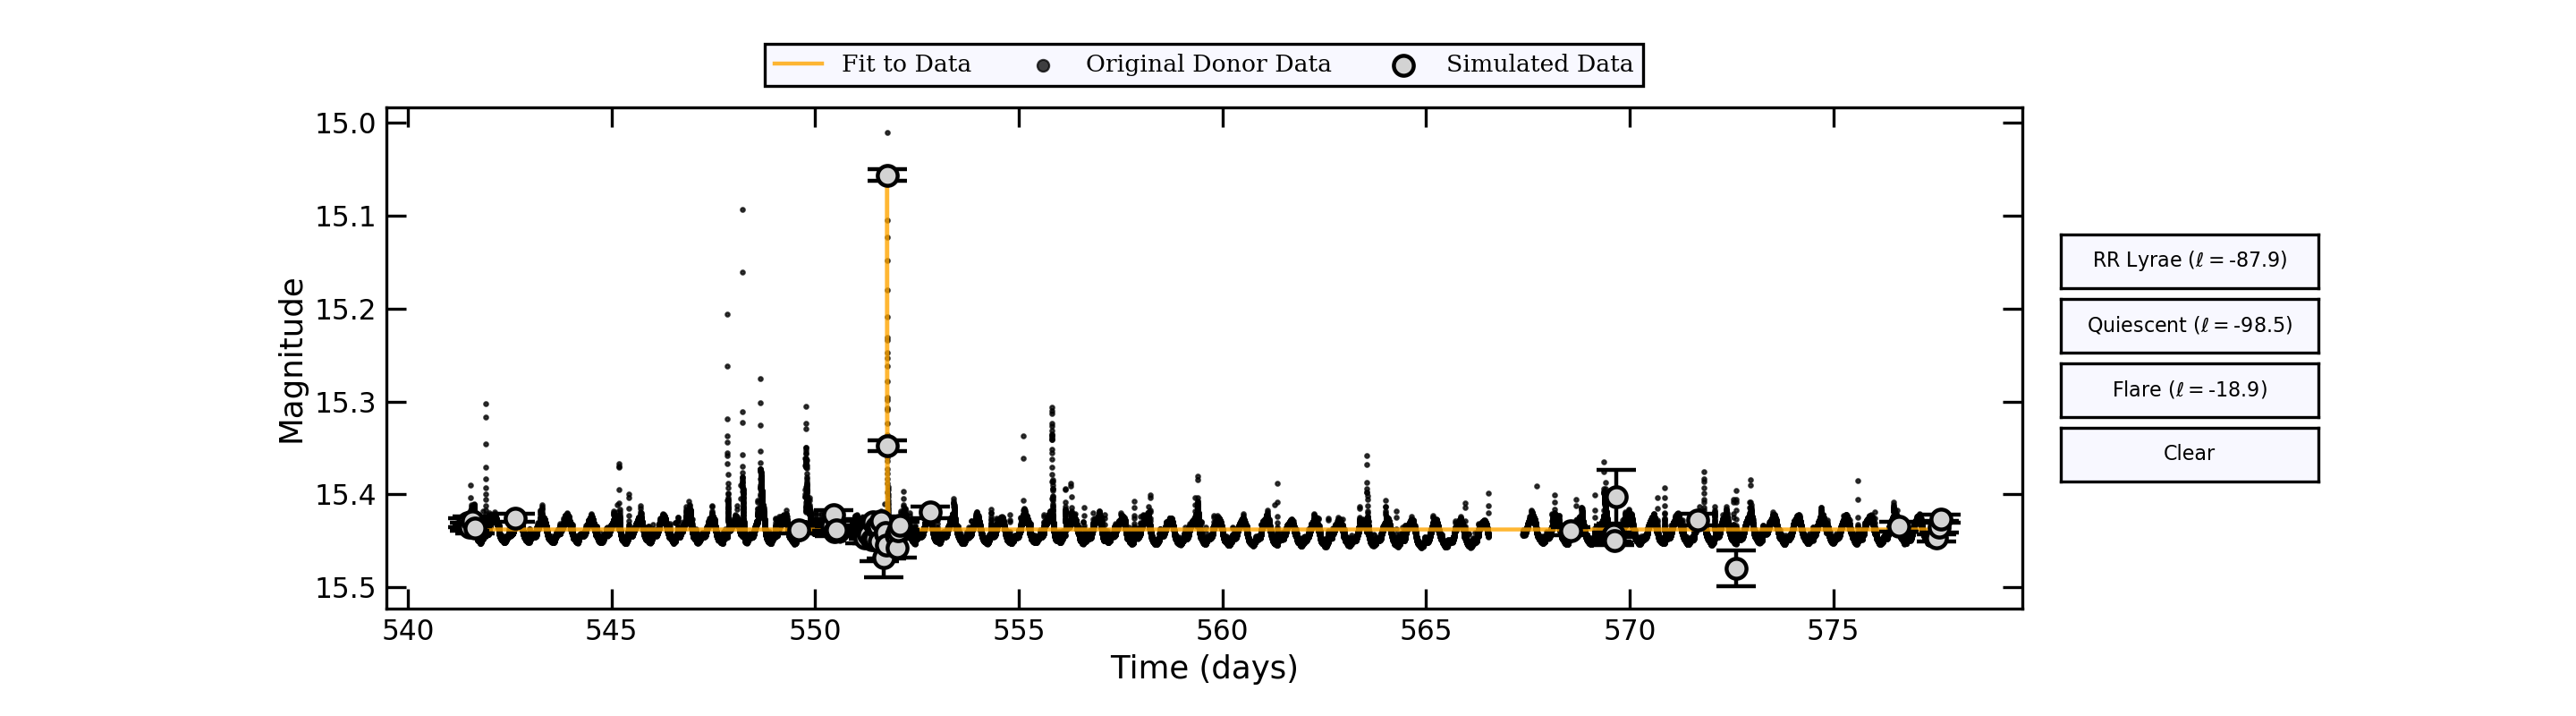

In [12]:
donor_lc_1 = np.genfromtxt(ex_dir+'donor_1.dat', names=True) # Load the first light-curve's original donor data as a structured numpy array

pyvan.plot_all_fits(tightened_lc_1_fit, donor_lightcurve=donor_lc_1) # Use optional argument 'donor_lightcurve' to pass in our original data.

The target is, in fact, a flare star. Though our flare template doesn't fit the original observations perfectly, it was good enough to unambiguously recover the flaring status of the star, despite the noisy and sparse simulated ground-based data.

****
## Example 2:
***

In [13]:
lc_2 = np.genfromtxt(ex_dir+'sim_2.dat', names=True) # Load the second light-curve as a structured numpy array

print lc_2.dtype.names

print lc_2.shape

('mjd', 'mag', 'magErr')
(15,)


In [14]:
lc_2_fit = pyvan.fit_target(data = lc_2, filt = 'g', threshold=None)

In application to real data, we typically only fit for RR Lyrae templates if the result of the flare and quiescent fits indicate a promising flare candidate (ie if we require a particular value for both flare-quiescent log(L) and flare-rrlyrae log(L), then there's no reason to continue fitting if the flare-quiescent value isn't met. Because RR Lyrae fitting takes up >90% of time for fitting each target, this procedure speeds up processing times immensely.

Any similar threshold can be supplied to the software using the "threshold" keyword. After each template is fit, the current fit dictionary is passed to the function supplied for "threshold".  The function should answer the question "should the fitting stop?", returning True if the target failed to meet some criteria and returning False if the target has not yet been ruled inviable. 

In this case, we set threshold to None to fit all three default templates regardless of the outcome of the first two.

The default threshold function for easy reference:

    def _default_failure_threshold(target_fits):
        """
        Default threshold function for truncating fitting on a target. 
        Value of dl_fq_threshold is based on analysis in Lawson+(2019). 
        Returns True if the procedure is to skip further fits. 
        Additionally requires that the flare fit completed -- i.e. 
        that at least one flare event candidate was found according 
        to the function supplied by 'flare_cands'.
        """
        if 'flare' in target_fits:
            if not target_fits['flare']['fit']:
                return True  # If the flare fit has been attempted but failed (due to lack of candidates), returns True
            if 'quiescent' in target_fits:
                dl_fq_threshold = 10.44  # Determined with simulation fitting, see: Lawson+(2019)
                if target_fits['flare']['logL'] - target_fits['quiescent']['logL'] < dl_fq_threshold:
                    return True  # If the flare and quiet fit have completed but fall below threshold dl_fq value, returns True
        return False 

<IPython.core.display.Javascript object>


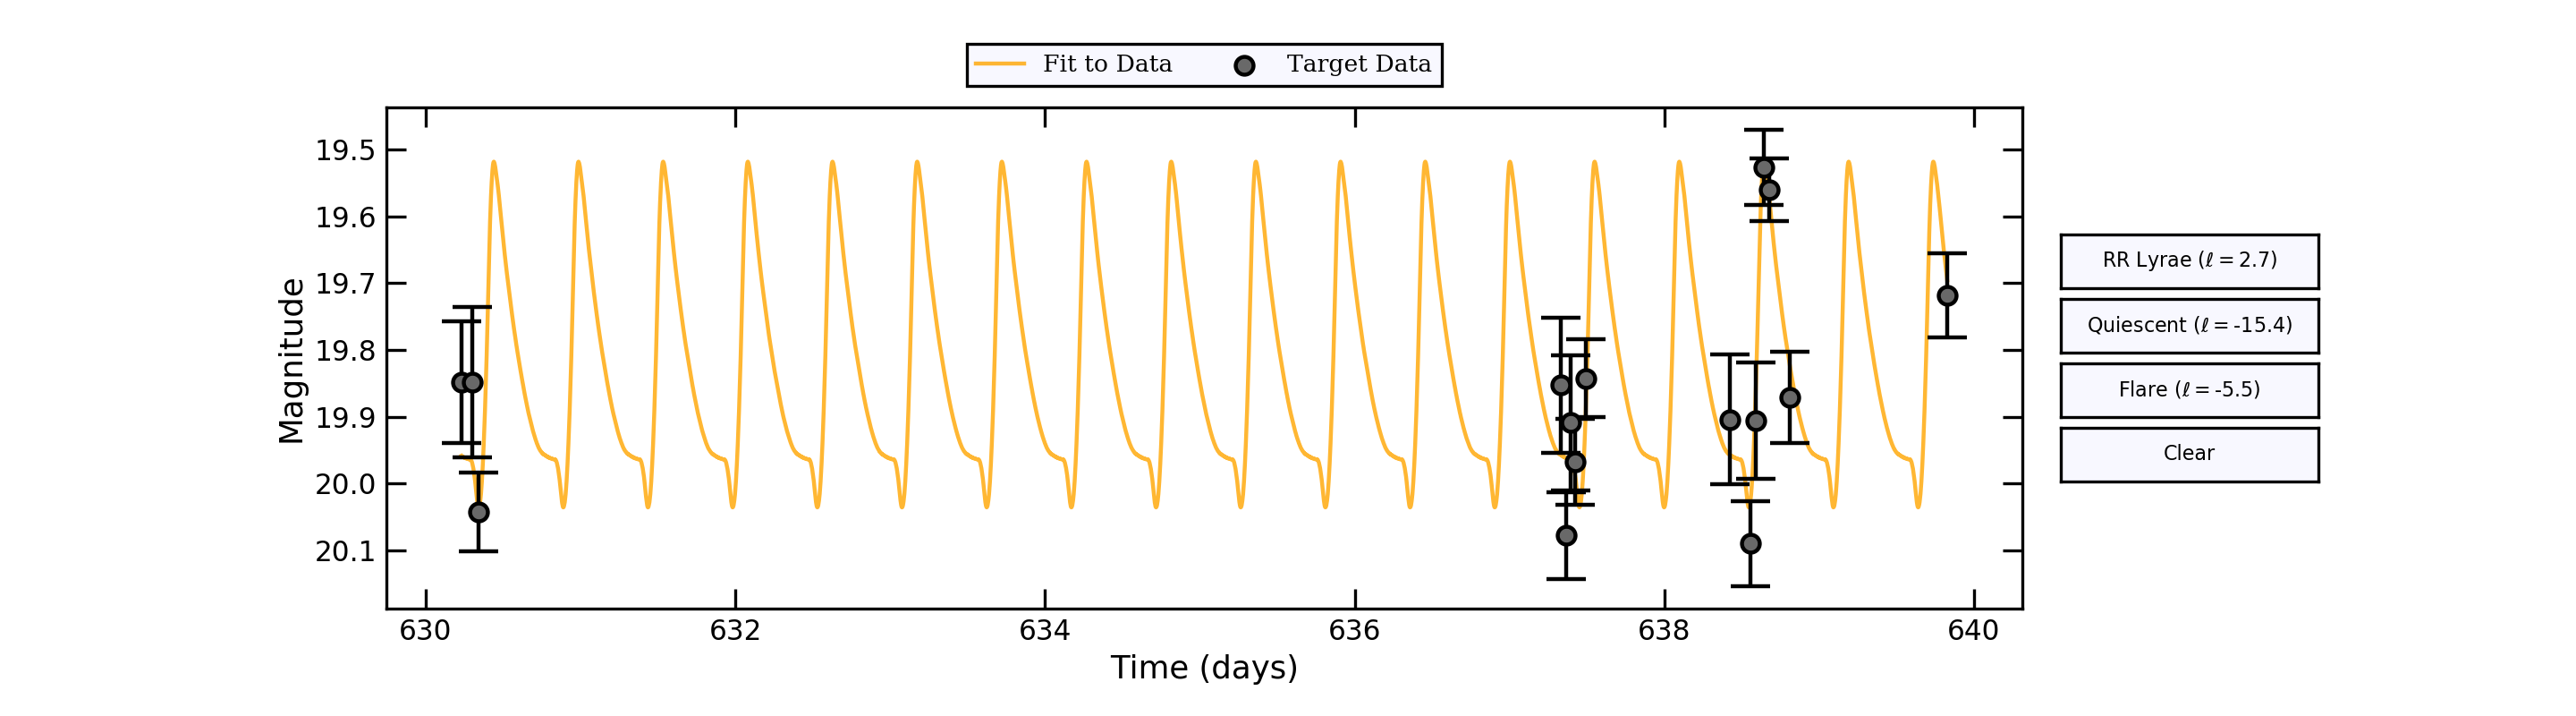

In [15]:
pyvan.plot_all_fits(lc_2_fit)

This light-curve is especially sparse -- with only 15 observations, and errors pushing a tenth of a magnitude. How close do we get with the determined fit?

<IPython.core.display.Javascript object>


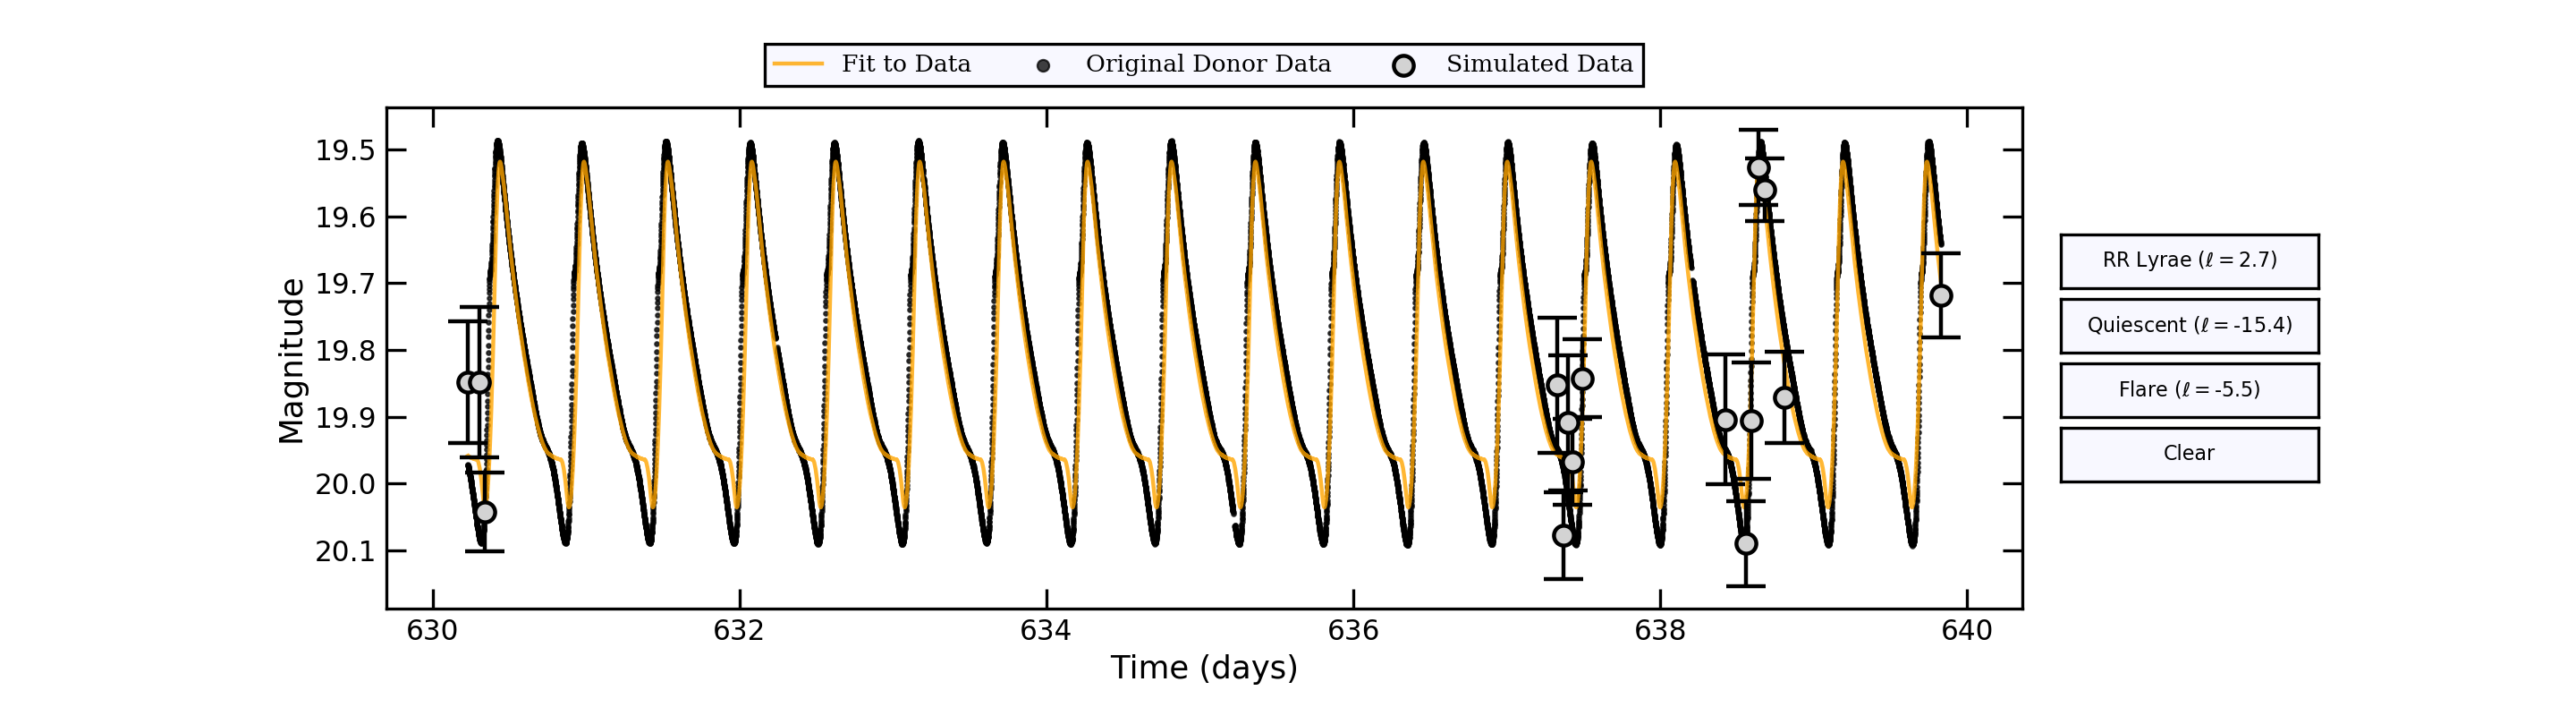

In [16]:
donor_lc_2 = np.genfromtxt(ex_dir+'donor_2.dat', names=True) # Load the second light-curve's original donor data as a structured numpy array

pyvan.plot_all_fits(lc_2_fit, donor_lightcurve = donor_lc_2) # Use optional argument 'donor_lightcurve' to pass in our original data.

The result is certainly not perfect --- but with the available information, we're able to eliminate the spurious flare candidate. 

It's also worth noting that g-band RR Lyrae templates don't describe RR Lyrae light-curves in the Kepler bandpass particularly accurately. In lieu of more appropriate templates, though, they perform well enough! 

__NOTE:__ PyVAN uses differential evolution to explore the available parameter spaces for each template. The algorithm does not guarantee that the best solution is identified with the procedure, or that each run will yield the same solution. This occurs most often for the RR Lyrae template when very few observations are available. If curating a sample of flare star candidates for follow-up or further analysis, it wouldn't hurt to rerun the procedure one or more additional times as time allows, keeping the best overall fit for each template. Alternatively, for prohibitively large samples, simply pushing the cuts to require higher metrics is another safe alternative. 

With that said: in 2500 simulated RR Lyrae light-curves, zero appeared in the region above the cuts I've suggested.

***
## Example 3: Application to larger samples

Once prepared, a large sample of light-curves can be processed as desired with a single command. To avoid massive filesizes, I haven't included a large sample of light-curves with the package. However, I'll supply some partial code in markdown form to hopefully make the procedure clear.

### Preparing Light-curves:

Many-object light-curve queries from large databases are often delivered in the form of a single text file, with each line corresponding to an observation, and where some object identifier is used to delineate photometry of different targets. Parsing multi-GB text files into individual light-curves can be tricky and extremely RAM inefficient if not carried out carefully. PyVAN includes a function for handling this, called  "parse_lc_file_to_list".

    parse_lc_file_to_list(lc_path, dtypes=None, oid_col='obj_id', time_col='mjd', return_oids=True)
    
The documentation explains the arguments above. As an example, say you have a text file containing light-curve observations at path 'my_path', and containing 4 columns: an up-to 20 digit integer identifier for each unique target (as in the PTF data I use), the MJD of the observation, the magnitude measured, and the magnitude error of the measurement (in that order). You could read in the light-curves for PyVAN as follows:

    dtypes = [('obj_id', np.uint64), ('mjd', '<f8'), ('mag', '<f8'), ('magErr', '<f8')] 
    # A list where each item is a tuple whose first entry is the string that will refer to the corresponding column, and the second is the data-type for the column. 
    
    lightcurves, obj_ids = pyvan.parse_lc_file_to_list(my_path, dtypes, oid_col='obj_id', time_col='mjd', return_oids=True)
    # oid_col and time_col tell the function which of the column names in 'dtypes' refer to the object identifier and times columns respectively.
    
The function returns a list of time-ordered light-curves and an array of object identifiers corresponding to the light-curves. 

If your light-curves are stored in a different format, you should prepare them such that you end up with a list of structured numpy arrays, each having columns labeled 'mjd', 'mag' and 'magErr' (you may have other columns as well, but those three are required). For example, to prepare our two light-curves above for fitting this way, we could just define:

    lightcurves = [lc_1, lc_2]

### Fitting the light-curves:
Once prepared, the sample can be fit as follows:

    fit_dict = pyvan.fit(lightcurves=lightcurves, n_cores=3, filt='g', obj_ids=obj_ids)
    
    # where n_cores indicates the number of cores to be used for the procedure, and 'filt' again indicates the filter to use 
    # the list of obj_ids (if provided) will serve as the keys in 'fit_dict', corresponding to the fit dictionary for each target, as "lc_1_fit" and "lc_2_fit" above. 
    # If no obj_ids are given, the function returns a dictionary in which each light-curve is keyed by an integer (ascending from 0). 
    # If preferred, a list of strings can be used instead of integers to key targets
    # (see documentation for more options or details)
    
Note: By default the procedure assumes an exposure time of 60 seconds --  this can be changed using the 'expt' argument for pyvan.fit or pyvan.fit_target

This can take quite some time for large samples. It may be helpful to split your sample up to allow intermittent saving of results from RAM. Once completed, the resulting dictionary can be saved using 'pickle':
    
    import pickle
    pickle.dump(fit_dict, open('/my_dir/pyvan_fits.p','wb'))
    
This can be loaded for later use by:

    import pickle
    fit_dict = pickle.load(open('/my_dir/pyvan_fits.p', 'rb'))

### Visualizing the results:
Individual fits can be inspected as in the examples above. A KDE scatter plot of 'flare-quiescent' versus 'flare-rrlyrae' log-likelihood differences for the sample can be created as well, with lines indicating the acceptance thresholds given in Example 1 if desired:

    pyvan.logL_kde_scatter(fit_dict, xy_cut=(10.44, 11.26))
    # see documentation for more options

Here's the result for a sample of ~2500 simulated flaring targets:

<img src="scatter_ex.png" width="1000" height="1000">